## Spectral grid fitting for the SALT spectra

We could do this with BT-Settl

The spectra are available here, on a one-by-one basis:

http://svo2.cab.inta-csic.es/theory/newov2/index.php?models=bt-settl


The spectra then need to be rotationally broadened. The broadening can be done with the eniric python package:

https://eniric.readthedocs.io/en/latest/

and the sampling to the instrument resolution of SALT's spectrograph can be done with a native astropy tool via "convolve":

https://docs.astropy.org/en/stable/convolution/


CARMENES spectra:

http://carmenes.cab.inta-csic.es/gto/jsp/reinersetal2018.jsp

In [13]:
from scipy.signal import correlate

In [2]:
import numpy as np
import pandas as pd

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import R_sun, c
import astropy.units as u

from scipy import interpolate

# Get spectra

In [3]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"
sp1 = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
model = pd.read_csv(f"{dirr}/btsettl/2700K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
sp2 = pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sp3 = pd.read_csv(f"{dirr}/salt/R202002080014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
from astropy.io import fits
hdu = fits.open(f"{dirr}/carmenes/carmenes_cnleo_vis.fits")

lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
sp4 = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
sp4 = sp4.dropna(how="any")
sp4.lambd = sp4.lambd - 2.6343301463011812

# Pick spectral regions

NameError: name 'specs' is not defined

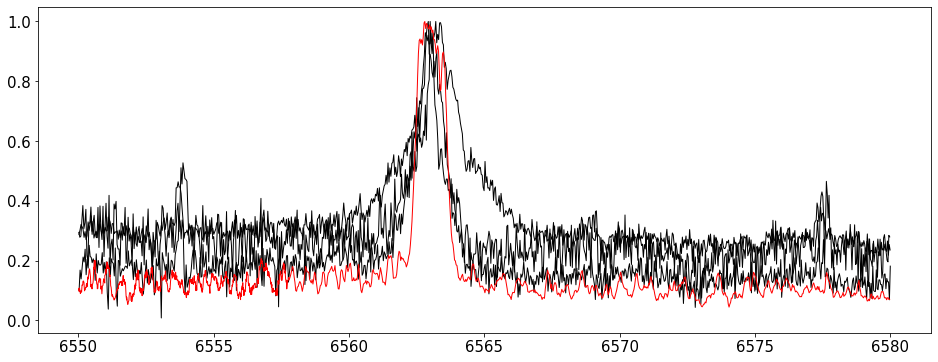

In [4]:
plt.figure(figsize=(16,6))
# for sp in [sp1, sp2, sp3]:
#     plt.errorbar(sp.lambd, sp.flux/, 
#                  yerr=sp.flux_err, c="k", linewidth=1, label="SALT")
    

wavmin, wavmax = 6550, 6580
for sp in [sp1, sp2, sp3]:
    wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    plt.plot(wav,mflux / np.max(mflux), c="k", linewidth=1, label="SALT")

#sp4 = model
sp44 = sp4[(sp4.lambd>wavmin) & (sp4.lambd<wavmax)]
plt.plot(sp44.lambd, sp44.flux/sp44.flux.max(), 
              c="r", linewidth=1, label="CN Leo")

for col in specs:
    plt.plot(specs.index, specs[col])
plt.axvline(6562.8)
plt.xlim(7000, 7200)
plt.xlim(6554,6572)
#plt.ylim(-100,1e5)
plt.ylim(0,1.1)
plt.legend();

In [5]:
sp44.lambd.values[np.argmax(sp44.flux)] - 6562.8

0.0

In [6]:
mask = pd.read_csv(f"{dirr}/salt/no_tellur_regions.csv")
mask

,wavmin,wavmax
0,7680,7720
1,7750,8100
2,7000,7200
3,7330,7550
4,8380,8700


In [7]:
wavmin, wavmax = 6555, 6570#mask.wavmin[2], mask.wavmax[2]
sp = sp2
model=sp4
wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"lambd"].values 
mflux = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"flux"].values


mflux = mflux / np.max(mflux)
mflux = mflux - np.min(mflux)
wav.shape, sflux.shape


NameError: name 'sflux' is not defined

In [200]:
sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
f = interpolate.interp1d(swav, sflux,fill_value="extrapolate")
sfluxinterp = f(wav)
sfluxinterp = sfluxinterp / np.max(sfluxinterp)
wav.shape, sfluxinterp.shape

((640,), (640,))

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [201]:
from eniric import broaden

In [11]:
vsinis = np.arange(5,150,5)
vsinis

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145])

In [203]:
specs = pd.DataFrame({"wav":wav})

for vsini in vsinis:
    specs[vsini] = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini)


100%|██████████| 640/640 [00:00<00:00, 765.07it/s]


In [8]:
#specs.to_csv(f"../../data/eniric/{wavmin}_{wavmax}_cnleo.csv",index=False)
specs = pd.read_csv(f"../../data/eniric/{wavmin}_{wavmax}_cnleo.csv")
specs = specs.set_index("wav")
specs

,5,10,15,20,25,30,35,40,45,50,...,100,105,110,115,120,125,130,135,140,145
wav,,,,,,,,,,,,,,,,,,,,,
6555.002927,0.022746,0.020926,0.020393,0.020517,0.020529,0.020437,0.020279,0.020274,0.020096,0.019804,...,0.019734,0.019749,0.019768,0.019808,0.019871,0.019910,0.019941,0.019976,0.019983,0.019965
6555.014412,0.022674,0.020880,0.020338,0.020532,0.020542,0.020415,0.020278,0.020265,0.020085,0.019803,...,0.019740,0.019749,0.019768,0.019808,0.019875,0.019915,0.019944,0.019980,0.019988,0.019973
6555.023565,0.022533,0.020834,0.020298,0.020548,0.020549,0.020402,0.020280,0.020257,0.020076,0.019800,...,0.019746,0.019750,0.019768,0.019808,0.019879,0.019919,0.019946,0.019984,0.019993,0.019978
6555.044199,0.022084,0.020729,0.020248,0.020551,0.020560,0.020360,0.020279,0.020229,0.020048,0.019792,...,0.019754,0.019752,0.019768,0.019809,0.019884,0.019927,0.019952,0.019991,0.020002,0.019989
6555.045032,0.022067,0.020724,0.020247,0.020551,0.020561,0.020358,0.020279,0.020228,0.020047,0.019791,...,0.019754,0.019752,0.019767,0.019809,0.019884,0.019928,0.019952,0.019991,0.020002,0.019990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569.862008,0.014870,0.016422,0.016977,0.017046,0.016694,0.016283,0.016178,0.016305,0.016376,0.016412,...,0.016523,0.016503,0.016497,0.016522,0.016584,0.016594,0.016576,0.016552,0.016513,0.016463
6569.890887,0.016352,0.017092,0.017236,0.017095,0.016738,0.016320,0.016249,0.016351,0.016409,0.016436,...,0.016526,0.016500,0.016496,0.016519,0.016579,0.016591,0.016576,0.016548,0.016506,0.016451
6569.919761,0.018067,0.017795,0.017477,0.017107,0.016748,0.016362,0.016333,0.016399,0.016439,0.016463,...,0.016527,0.016498,0.016499,0.016520,0.016570,0.016586,0.016575,0.016543,0.016498,0.016439


In [9]:
# convert wavelength to difference in velocity
l0 = wav[int(len(wav)/2)]
v = ((wav-l0)/wav * c).to("km/s")

0.927719059161395 0.93050325 29.839672829784902
0.9473341641029493 0.93050325 30.569017428109046
0.7630402774466828 0.93050325 28.9480613114156


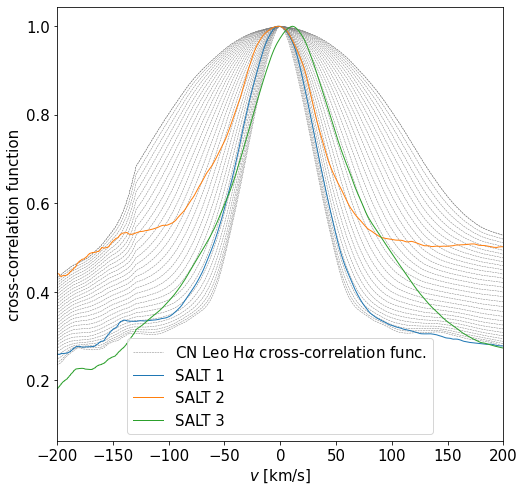

In [15]:
corrf = pd.DataFrame({"v":v})
plt.figure(figsize=(8,8))

for vsini, broad_spectrum in zip(vsinis, specs):
    # Convolve data
    if vsini>0:
        corr = correlate(specs[broad_spectrum],mflux, mode="same")
        me = np.max(corr)
        corrf[vsini] = corr/me
        plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed")#,label=f"{vsini} km/s")
plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed",label=r"CN Leo H$\alpha$ cross-correlation func.")
# corr = correlate(mflux,mflux, mode="same")
# me = np.max(corr)
# plt.plot(v,corr/me, c="grey", linewidth=0.5,label=f"0 km/s")
for sp, num in [(sp1,"1"), (sp2,"2"), (sp3,"3")]:#,sp4]:
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
    sfluxinterp = f(wav)
    sfluxinterp = sfluxinterp / np.max(sfluxinterp)
    sfluxinterp = sfluxinterp - np.min(sfluxinterp)
    
#     corr = correlate(mflux,sfluxinterp, mode="same")
#     me = np.max(corr)
#     corrf["salt"] = corr/me
#     print(np.max(sfluxinterp),np.max(mflux), np.max(corr))
#     plt.plot(v-45*u.km/u.s,corr/me, label=f"SALT", c="r", linewidth=1)
    
    corr = correlate(sfluxinterp,mflux, mode="same")
    me = np.max(corr)
    corrf["salt" + num] = corr/me
    print(np.max(sfluxinterp),np.max(mflux), np.max(corr))
    plt.plot(v,corr/me, label=f"SALT {num}", linewidth=1)
w = 200
plt.xlim(-w,w)
#plt.ylim(0.65,1.2)
plt.xlabel(r"$v$ [km/s]", fontsize=15)
plt.ylabel("cross-correlation function", fontsize=15)
plt.legend(fontsize=15)
#plt.savefig("../plots/vsini/CNleo_Halpha_cross_corr.png", dpi=300)

In [16]:
#corrf = corrf[(corrf.v>-1180) & (corrf.v<1180)]
corrf = corrf.set_index("v")

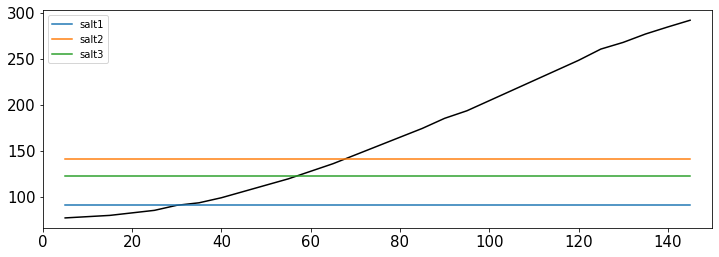

In [20]:
thresh=0.6
plt.figure(figsize=(12,4))
FWHM = corrf.apply(lambda x:x.index[np.where(x>thresh)[0][-1]]-x.index[np.where(x>thresh)[0][0]], axis=0)
plt.plot(FWHM.index[:-3],FWHM.values[:-3], c="k")
for i in [-3,-2,-1]:
    plt.plot([FWHM.index[0],FWHM.index[-4]],[FWHM.values[i]]*2, label=FWHM.index[i])
plt.xlim(0,150)
plt.legend()

Rough first estimates:  

- 45 km/s, 81 km/s, 103 km/s (thresh 0.7)
- 47 km/s, 115 km/s, 118 km/s (thresh 0.65)

In [258]:
FWHM

5         79.469945
10        82.210525
15        84.951128
20        87.691756
25        90.432410
30        95.913794
35       101.395278
40       106.876845
45       112.358479
50       120.581017
55       128.803605
60       137.026186
65       147.989510
70       157.572300
75       168.534295
80       179.495762
85       190.456561
90       202.799502
95       213.759602
100      227.459128
105      238.418471
110      250.763582
115      261.186221
120      270.719109
125      279.376365
130      288.908375
135      298.437465
140      306.555908
145      316.078153
salt1    115.142210
salt2    263.715827
salt3    269.604360
dtype: float64